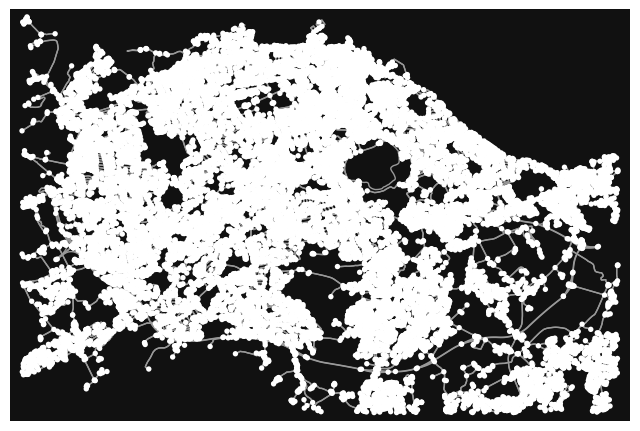

WS: Communal Bin             3993
WS: Packaging                3435
WS: Bottle Bank - Mixed      2807
WS: Food Waste Communal      2645
WS: Paper Bank                994
WS: Chamberlain Bin           944
WS: Side Loading Communal     896
WS: Textile Bank               74
WS: Bottle Bank - Green        31
WS: Bottle Bank - Clear        31
WS: Bottle Bank - Brown        30
WS: Book Bank                   4
WS: Can Banks                   1
WS: Bottle Bank - Red           1
Name: feature_type_name, dtype: int64


In [1]:
import pandas as pd
import pyproj
import osmnx as ox

# Read the CSV file into a DataFrame
df = pd.read_csv('data/Communal_Bins.csv')

# Define the BNG and WGS84 coordinate systems using the new syntax
bng = pyproj.CRS.from_epsg(27700)
wgs84 = pyproj.CRS.from_epsg(4326)

# Create a transformer object to convert between the CRS
transformer = pyproj.Transformer.from_crs(bng, wgs84)

# Convert the BNG coordinates to decimal longitude and latitude
lat, lon = transformer.transform(df['EASTING'].values, df['NORTHING'].values)

# Add the new columns to the DataFrame
df['lon'] = lon
df['lat'] = lat

north = 55.9899
south = 55.8784
east = -3.0418
west = -3.3374

G = ox.graph_from_bbox(north, south, east, west, network_type='drive_service', simplify=True)
ox.plot_graph(G)

df_in_map = df[(df['lat'] > south) & (df['lat'] < north) & (df['lon'] > west) & (df['lon'] < east)]

print(df_in_map['feature_type_name'].value_counts())

In [3]:

import json
with open('data/Edinburgh_Ward_Boundaries.geojson') as f:
    geojson = json.load(f)


#geojson to geodataframe
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(geojson['features'])


#check if point is in polygon
from shapely.geometry import Point
def is_in_polygon(point, polygon):
    return polygon.contains(point)

#locate bin in which ward
def locate_bin_in_ward(bin):
    point = Point(bin['lon'], bin['lat'])
    for index, ward in gdf.iterrows():
        if is_in_polygon(point, ward['geometry']):
            return ward['Ward_Name']
    return None

df_in_map['ward'] = df_in_map.apply(locate_bin_in_ward, axis=1)

df_in_map

/tmp/ipykernel_9576/3439605343.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_map['ward'] = df_in_map.apply(locate_bin_in_ward, axis=1)


,X,Y,OBJECTID,site_name,feature_type_name,EASTING,NORTHING,asset_id_code,site_code,number_bins,bin_size,lon,lat,ward
0,323246.25,672436.30,2481497,Mcleod Street,WS: Bottle Bank - Mixed,323246,672436,NaN,7903443,1,660.0,-3.230301,55.938824,Sighthill / Gorgie
1,323204.25,672553.02,2481498,Mcleod Street,WS: Bottle Bank - Mixed,323204,672553,NaN,7903443,1,660.0,-3.231007,55.939868,Sighthill / Gorgie
2,322903.52,672360.14,2481499,Smithfield Street,WS: Bottle Bank - Mixed,322904,672360,NaN,7903260,1,660.0,-3.235753,55.938086,Sighthill / Gorgie
3,322903.63,672360.01,2481500,Smithfield Street,WS: Packaging,322904,672360,NaN,7903260,2,1280.0,-3.235753,55.938086,Sighthill / Gorgie
4,322899.95,672336.39,2481501,Smithfield Street,WS: Bottle Bank - Mixed,322900,672336,NaN,7903260,1,660.0,-3.235810,55.937870,Sighthill / Gorgie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16113,324305.43,674567.21,2497693,Bedford Court,WS: Chamberlain Bin,324305,674567,NaN,7900003,1,940.0,-3.213951,55.958134,Inverleith
16114,324319.35,674566.85,2497694,Bedford Court,WS: Chamberlain Bin,324319,674567,NaN,7900003,1,940.0,-3.213727,55.958136,Inverleith
16115,324338.60,674574.63,2497695,Bedford Court,WS: Chamberlain Bin,324339,674575,NaN,7900003,1,940.0,-3.213409,55.958211,Inverleith
16116,324327.00,674568.00,2497696,Bedford Court,WS: Chamberlain Bin,324327,674568,NaN,7900003,1,940.0,-3.213599,55.958146,Inverleith


In [ ]:
df_in_map.to_csv('data/Bins_cleaned.csv', index=False)